<a href="https://colab.research.google.com/github/dohb128/SW2025/blob/main/SW25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

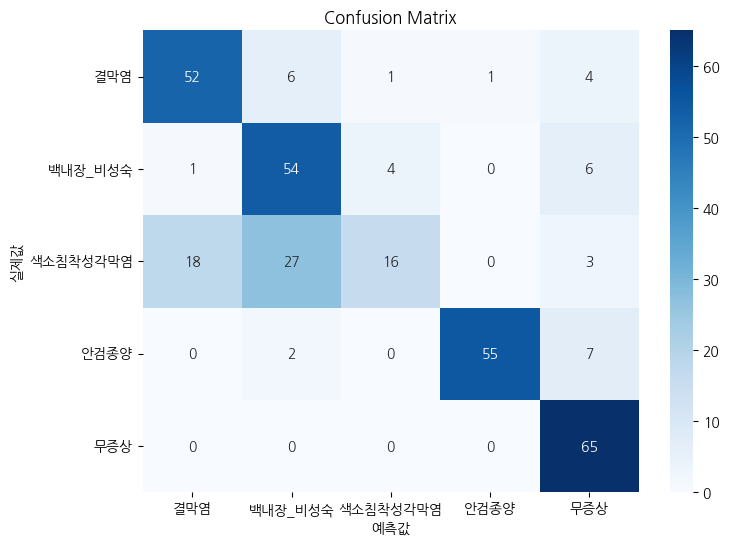


[Classification Report]
              precision    recall  f1-score   support

         결막염       0.73      0.81      0.77        64
     백내장_비성숙       0.61      0.83      0.70        65
    색소침착성각막염       0.76      0.25      0.38        64
        안검종양       0.98      0.86      0.92        64
         무증상       0.76      1.00      0.87        65

    accuracy                           0.75       322
   macro avg       0.77      0.75      0.73       322
weighted avg       0.77      0.75      0.73       322



In [8]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔄 1. 폰트 경로 설정 (Ubuntu 기준)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 🔄 2. 폰트 캐시 제거 및 재생성
font_dirs = ['/usr/share/fonts/truetype/nanum']
for font_dir in font_dirs:
    fm.fontManager.addfont(os.path.join(font_dir, 'NanumGothic.ttf'))

# 🔄 3. matplotlib에 반영
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 🔄 4. Confusion Matrix 출력
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(len(label_to_idx))],
            yticklabels=[idx_to_label[i] for i in range(len(label_to_idx))])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

# 🔄 5. Classification Report 출력
print("\n[Classification Report]")
print(classification_report(y_true, y_pred, target_names=[idx_to_label[i] for i in range(len(label_to_idx))]))


In [3]:
# 시스템 명령어로 압축 해제 (한글 깨짐 방지)
!apt-get install -y unzip
!unzip -O cp949 '/content/drive/MyDrive/자료.zip' -d '/content/dataset'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/무증상/crop_D4_0c1bdac8-60a5-11ec-8402-0a7404972c70.json  
  inflating: /content/dataset/무증상/crop_D4_0c1bdac8-60a5-11ec-8402-0a7404972c70.png  
  inflating: /content/dataset/무증상/crop_D4_0c2d4a29-60a5-11ec-8402-0a7404972c70.json  
  inflating: /content/dataset/무증상/crop_D4_0c2d4a29-60a5-11ec-8402-0a7404972c70.png  
  inflating: /content/dataset/무증상/crop_D4_0c64cbab-60a5-11ec-8402-0a7404972c70.json  
  inflating: /content/dataset/무증상/crop_D4_0c64cbab-60a5-11ec-8402-0a7404972c70.png  
  inflating: /content/dataset/무증상/crop_D4_0c916a9f-60a5-11ec-8402-0a7404972c70.json  
  inflating: /content/dataset/무증상/crop_D4_0c916a9f-60a5-11ec-8402-0a7404972c70.png  
  inflating: /content/dataset/무증상/crop_D4_245a79dd-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: /content/dataset/무증상/crop_D4_245a79dd-60a5-11ec-8402-0a7404972c70.json  
  inflating: /content/dataset/무증상/crop_D4_245f6f2a-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: /content/da

Loading 무증상: 100%|██████████| 500/500 [00:03<00:00, 131.49it/s]



⚡ bbox 에러로 전체 이미지 사용된 파일 수: 290개
✅ 최종 로딩된 이미지 수: 2500개

🚀 데이터 로드 완료. 이제 학습을 시작합니다...

Epoch 1/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.4775 - loss: 1.4982 - val_accuracy: 0.5794 - val_loss: 1.0536
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6627 - loss: 0.8562 - val_accuracy: 0.7243 - val_loss: 0.8038
Epoch 3/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7079 - loss: 0.8066 - val_accuracy: 0.6986 - val_loss: 0.8260
Epoch 4/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7426 - loss: 0.6988 - val_accuracy: 0.6612 - val_loss: 0.8244
Epoch 5/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7414 - loss: 0.6832 - val_accuracy: 0.7173 - val_loss: 0.7574
Epoch 6/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7662 - loss: 0.6370 - val_accuracy: 0.7290 - val_loss: 0.8014
Epoch 7/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7777 - loss: 0.6054 - val_accuracy: 0.7033 - val_loss: 0.8703
Epoch 8/8
110/1

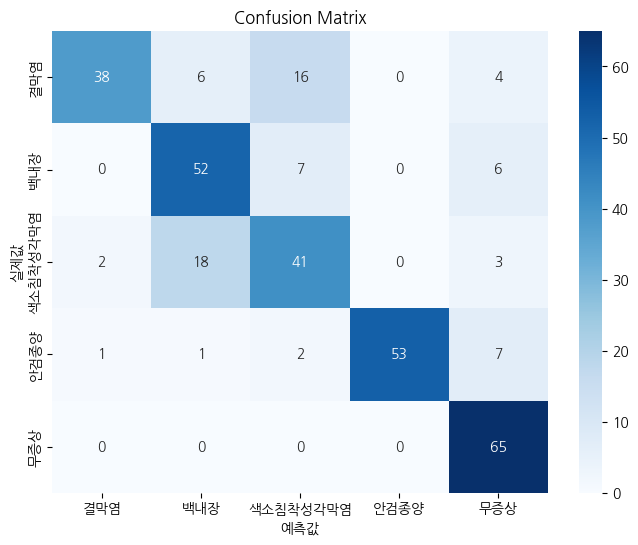


[Classification Report]
              precision    recall  f1-score   support

         결막염       0.93      0.59      0.72        64
         백내장       0.68      0.80      0.73        65
    색소침착성각막염       0.62      0.64      0.63        64
        안검종양       1.00      0.83      0.91        64
         무증상       0.76      1.00      0.87        65

    accuracy                           0.77       322
   macro avg       0.80      0.77      0.77       322
weighted avg       0.80      0.77      0.77       322



In [12]:
# 🚀 Transfer Learning + Custom 강화 모델

# 기본 import
import os
import numpy as np
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# TensorFlow import
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 📂 파일 경로 설정
base_path = '/content/dataset'

class_dirs = {
    '결막염': os.path.join(base_path, '결막염'),
    '백내장': os.path.join(base_path, '백내장'),
    '색소침착성각막염': os.path.join(base_path, '색소침착성각막염'),
    '안검종양': os.path.join(base_path, '안검종양'),
    '무증상': os.path.join(base_path, '무증상')
}

label_to_idx = {label: idx for idx, label in enumerate(class_dirs)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# 🎯 이미지 로드
images = []
labels = []
bbox_error_count = 0

random.seed(42)

for label_name, dir_path in class_dirs.items():
    json_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]
    selected_json_files = random.sample(json_files, min(len(json_files), 500))

    for filename in tqdm(selected_json_files, desc=f"Loading {label_name}"):
        json_path = os.path.join(dir_path, filename)
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_filename = 'crop_' + data['images']['meta']['file_name']
            image_path = os.path.join(dir_path, image_filename)
            if not os.path.exists(image_path):
                continue

            img = Image.open(image_path).convert('RGB')

            try:
                bbox = data['label']['label_bbox']
                x_min, y_min, x_max, y_max = map(int, bbox)
                cropped = img.crop((x_min, y_min, x_max, y_max)).resize((224, 224))
            except Exception:
                bbox_error_count += 1
                cropped = img.resize((224, 224))

            images.append(img_to_array(cropped))
            labels.append(label_to_idx[label_name])

        except Exception as e:
            print(f"⚠️ 오류 - {filename}: {e}")

print(f"\n⚡ bbox 에러로 전체 이미지 사용된 파일 수: {bbox_error_count}개")
print(f"✅ 최종 로딩된 이미지 수: {len(images)}개")
print("\n🚀 데이터 로드 완료. 이제 학습을 시작합니다...\n")

# 데이터 전처리
X = np.array(images, dtype='float32')
X = preprocess_input(X)  # MobileNetV2 전처리

y = to_categorical(labels, num_classes=len(label_to_idx))

# 데이터 분할
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=3/7, random_state=42, stratify=y_temp)

# 📚 MobileNetV2 기반 모델 만들기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Feature extractor로만 사용

x = base_model.output
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_to_idx), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️ 학습 시작
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=16
)

# 📈 테스트셋 평가
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# 🔄 한글 폰트 설정 (NanumGothic 사용)
import matplotlib.font_manager as fm
!apt-get install -y fonts-nanum
!fc-cache -fv
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 🔄 Confusion Matrix 출력
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(len(label_to_idx))],
            yticklabels=[idx_to_label[i] for i in range(len(label_to_idx))])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

# 🔄 Classification Report 출력
print("\n[Classification Report]")
print(classification_report(y_true, y_pred, target_names=[idx_to_label[i] for i in range(len(label_to_idx))]))


In [11]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# --- 테스트 폴더 경로 ---
test_folder = '/content/dataset/테스트'

# --- 파일 리스트 ---
test_images = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# --- 파일명 패턴을 실제 라벨로 매핑하는 함수 ---
def get_true_label_from_filename(filename):
    if filename.startswith('결유'):
        return '결막염_유'
    elif filename.startswith('백성'):
        return '백내장_성숙'
    elif filename.startswith('색소침착성각막염'):
        return '색소침착성각막염'
    elif filename.startswith('안검종양'):
        return '안검종양'
    else:
        return None  # 예외처리용

# --- 테스트 수행 ---
correct = 0
total = 0

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)

    # 이미지 로드 및 전처리
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # 모델 예측
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_label = idx_to_label[pred_class]

    # 실제 정답 추론
    true_label = get_true_label_from_filename(img_name)

    # 비교
    is_correct = (pred_label == true_label)
    if is_correct:
        correct += 1
    total += 1

    # 결과 출력
    result_text = "⭕ 정답" if is_correct else "❌ 오답"
    print(f"🖼️ 파일명: {img_name} → 예측: {pred_label} / 정답: {true_label} → {result_text}")

# --- 최종 정확도 출력 ---
accuracy = correct / total * 100
print(f"\n🎯 최종 테스트 정확도: {accuracy:.2f}% ({correct}/{total}개 맞춤)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🖼️ 파일명: 백성3.jpg → 예측: 백내장_비성숙 / 정답: 백내장_성숙 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🖼️ 파일명: 안검종양4.jpg → 예측: 안검종양 / 정답: 안검종양 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 안검종양1.jpg → 예측: 결막염 / 정답: 안검종양 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 결유2.jpg → 예측: 안검종양 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🖼️ 파일명: 색소침착성각막염3.jpg → 예측: 안검종양 / 정답: 색소침착성각막염 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 결유5.jpg → 예측: 색소침착성각막염 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🖼️ 파일명: 백성2.jpg → 예측: 색소침착성각막염 / 정답: 백내장_성숙 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 백성1.jpg → 예측: 백내장_비성숙 / 정답: 백내장_성숙 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🖼️ 파일명: 결유4.jpg → 예측: 백내장_비성숙 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 색소침착성각막염5.jpg → 예측: 색소침착성각막염 / 정답: 색소침착성각막염 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 색소침착성각막염2.jpg → 예측: 결막염 / 정답: 색소침착성각막염 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s